### Creating A New CNN

Hi! Welcome to $\texttt{stella}$, a package to identify stellar flares using $\textit{TESS}$ two-minute data. Here, we'll run through an example of how to create a convolutional neural network (CNN) model and how to use it to predict where flares are in your own light curves. Let's get started!

In [3]:
import os, sys
sys.path.insert(1, '/Users/arcticfox/Documents/GitHub/stella/')
import stella
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 20

#### 1.1 The Training Set

For this network, we'll be using the flare catalog presented in Günther et al. (2020), which were identified and hand-labeled using all stars observed at two-minute cadence in $\textit{TESS}$ Sectors 1 and 2. The catalog and the light curves can be downloaded through $\texttt{stella}$ with the following:

In [4]:
download = stella.DownloadSets(fn_dir='.')
download.download_catalog()

W0714 08:45:08.602910 4409996736 logger.py:204] AstropyDeprecationWarning: ./Guenther_2020_flare_catalog.txt already exists. Automatically overwriting ASCII files is deprecated. Use the argument 'overwrite=True' in the future.


Et voila! A table of flares. For this demo, we'll only be using a subset of targets. Please ignore this when creating your own CNN!!

And we'll download that subset of light curves.

In [5]:
download.flare_table = download.flare_table[0:100]
download.download_lightcurves()

  0%|          | 0/5 [00:00<?, ?it/s]//anaconda3/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)
 20%|██        | 1/5 [00:08<00:32,  8.23s/it]//anaconda3/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)
 40%|████      | 2/5 [00:18<00:26,  8.90s/it]//anaconda3/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)
 60%|██████    | 3/5 [00:27<00:17,  8.87s/it]//anaconda3/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)
 80%|████████  | 4/5

These light curve files are downloaded to the preset `fn_dir` set. The light curves are downloaded through $\texttt{lightkurve}$. They are then reformatted to `.npy` files to save space and the original FITS files are deleted. If you wish to keep the original FITS files, you can set `download.download_lightcurves(remove_fits=False)`.

First, we need to do a bit of pre-processing of our light curves. The details of this can be found in Feinstein et al. (submitted). The pre-processing is necessary to reformat the light curves such that the Tensorflow modules work. The recommended settings (such as the length of light curve fed into the neural network and the fractional balance of non-flare to flare examples) are the default in the `stella.FlareDataSet()` class. The only variables you must input is the directory to where you are storing the light curves and the catalog.

Other variables that can be set are:

- $\textit{cadences}$: The number of cadences the CNN looks at at one time. Default = 200.

- $\textit{frac_balance}$: This fixes the class imbalances between the flare and no-flare classes. This is useful because we have a lot more no-flare cases and by rebalancing, we can train the CNN better. Default = 0.73.

- $\textit{training}$: The percentage of the data set that is set aside for training. The typical split is 80% for the training, 10% for the validation, and 10% for the test sets. Default = 0.80.

- $\textit{validation}$: The remaining percentage to be split between the validation and test sets after the training set has been assigned. Default = 0.90.

More information on these variables can be found in the [API for stella.FlareDataSet()](http://adina.feinste.in/stella/api.html#stella.FlareDataSet).

If you downloaded the catalog through `stella.DownloadSets()` you can initialize the `FlareDataSet` class by calling:

`ds = stella.FlareDataSet(downloadSet=download)`

If you already have the catalog and light curves stored on your machine, you can call:

In [21]:
ds = stella.FlareDataSet(fn_dir='/Users/arcticfox/Documents/flares/lc/unlabeled',
                         catalog='/Users/arcticfox/Documents/flares/lc/unlabeled/catalog_per_flare_final.csv')

Reading in training set files.


100%|██████████| 865/865 [00:01<00:00, 434.38it/s]


5389 positive classes (flare)
17684 negative classes (no flare)
30.0% class imbalance



If you did not use the `DownloadSets` class, you can set the parameters `fn_dir` and `catalog` when initiating `stella.FlareDataSet`.

The TQDM loading bar tracks which light curve files have been read in for creating the data set. $\texttt{stella}$ will also print out the number of positive (flare) and negative (no flare) cases in the set as well as the class imbalance. Setting $\textit{frac_balance} = 0.73$ results in an imbalance of 30%, which is recommended for training CNNs.

We can take a look at some of the flares and no flares in the training set data.

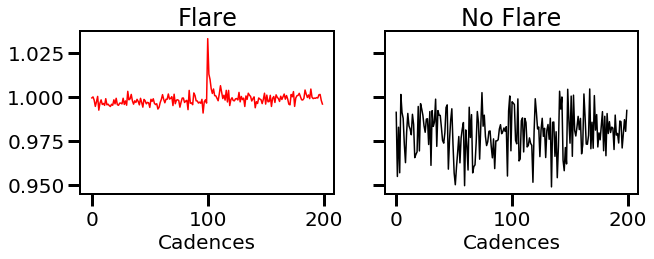

In [22]:
ind_pc = np.where(ds.train_labels==1)[0] # Flares
ind_nc = np.where(ds.train_labels==0)[0] # No flares

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3), 
                               sharex=True, sharey=True)
ax1.plot(ds.train_data[ind_pc[10]], 'r')
ax1.set_title('Flare')
ax1.set_xlabel('Cadences')
ax2.plot(ds.train_data[ind_nc[10]], 'k')
ax2.set_title('No Flare')
ax2.set_xlabel('Cadences');

That definitely looks like a flare on the left and definitely doesn't on the right!

#### 1.2 Creating & Training a Model

Step 1. Specifiy a directory where you'd like your models to be saved to. 

In [23]:
OUT_DIR = '/Users/arcticfox/Desktop/results/'

Step 2. Initialize the class! Call $\texttt{stella.ConvNN()}$ and pass in your directory and the $\texttt{stella.DataSet}$ object. If you're feeling adventerous, this is also the step where you can pass in a customized CNN architecture by passing in $\textit{layers}$, and what $\textit{optimizer}$, $\textit{metrics}$, and $\textit{loss}$ function you want to use. The default for each of these variables are described in the associated paper. 

In [24]:
cnn = stella.ConvNN(output_dir=OUT_DIR,
                    ds=ds)

To train your model, simply call $\texttt{cnn.train_models()}$. By default, this will train a single model over 350 epochs and will pass in a batch size = 64 (which means the CNN will see 64 light curves at a time while training) and use an initial random seed = 2. It's important to keep track of your random seeds so you can reproduce models later, if wanted. Calling this function will also predict on the validation set to give you an idea of how well your CNN is doing. 

However, if you pass in a list of seeds, then this function will train len(seeds) many models over the same number of epochs. This is useful for $\textit{ensembling}$, or running a bunch of models and averaging the predicted values over them. 

The models you create will automatically be saved to your output directory in the following file format: 'ensemble_s{0:04d}_i{1:04d}_b{2}.h5'.format(seed, epochs, frac_balance)

For this tutorial, we will train the CNN for 50 epochs, however we generally recommend training for $\textbf{at least 300 epochs}$ or until signs of overfitting are seen in the metrics. More information on that below.

In [29]:
cnn.train_models(seeds=2, epochs=200)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 200, 16)           128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 16)           0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 64)           3136      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0

18458/18458 [==============================] - 3s 140us/sample - loss: 0.0996 - accuracy: 0.9681 - precision: 0.9686 - recall: 0.8936 - val_loss: 0.0970 - val_accuracy: 0.9775 - val_precision: 0.9425 - val_recall: 0.9603
Epoch 64/200
18458/18458 [==============================] - 2s 135us/sample - loss: 0.1073 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.8900 - val_loss: 0.0922 - val_accuracy: 0.9744 - val_precision: 0.9368 - val_recall: 0.9527
Epoch 65/200
18458/18458 [==============================] - 2s 133us/sample - loss: 0.1280 - accuracy: 0.9597 - precision: 0.9658 - recall: 0.8591 - val_loss: 0.1154 - val_accuracy: 0.9688 - val_precision: 0.9117 - val_recall: 0.9565
Epoch 66/200
18458/18458 [==============================] - 2s 133us/sample - loss: 0.1054 - accuracy: 0.9672 - precision: 0.9722 - recall: 0.8860 - val_loss: 0.0749 - val_accuracy: 0.9766 - val_precision: 0.9612 - val_recall: 0.9357
Epoch 67/200
18458/18458 [==============================] - 2s 132us/sample -

Epoch 133/200
18458/18458 [==============================] - 2s 131us/sample - loss: 0.0965 - accuracy: 0.9697 - precision: 0.9690 - recall: 0.8999 - val_loss: 0.1128 - val_accuracy: 0.9575 - val_precision: 0.8954 - val_recall: 0.9225
Epoch 134/200
18458/18458 [==============================] - 2s 130us/sample - loss: 0.0885 - accuracy: 0.9717 - precision: 0.9682 - recall: 0.9098 - val_loss: 0.0859 - val_accuracy: 0.9701 - val_precision: 0.9064 - val_recall: 0.9698
Epoch 135/200
18458/18458 [==============================] - 2s 129us/sample - loss: 0.0915 - accuracy: 0.9706 - precision: 0.9682 - recall: 0.9049 - val_loss: 0.0814 - val_accuracy: 0.9749 - val_precision: 0.9274 - val_recall: 0.9660
Epoch 136/200
18458/18458 [==============================] - 2s 129us/sample - loss: 0.0927 - accuracy: 0.9712 - precision: 0.9699 - recall: 0.9058 - val_loss: 0.1020 - val_accuracy: 0.9688 - val_precision: 0.8988 - val_recall: 0.9735
Epoch 137/200
18458/18458 [==============================] -

Epoch 168/200
18458/18458 [==============================] - 2s 134us/sample - loss: 0.0885 - accuracy: 0.9733 - precision: 0.9723 - recall: 0.9128 - val_loss: 0.2243 - val_accuracy: 0.9207 - val_precision: 0.7464 - val_recall: 0.9905
Epoch 169/200
18458/18458 [==============================] - 2s 133us/sample - loss: 0.0760 - accuracy: 0.9772 - precision: 0.9778 - recall: 0.9240 - val_loss: 0.1398 - val_accuracy: 0.9545 - val_precision: 0.8464 - val_recall: 0.9792
Epoch 170/200
18458/18458 [==============================] - 3s 137us/sample - loss: 0.0936 - accuracy: 0.9717 - precision: 0.9716 - recall: 0.9063 - val_loss: 0.1020 - val_accuracy: 0.9649 - val_precision: 0.9870 - val_recall: 0.8582
Epoch 171/200
18458/18458 [==============================] - 2s 135us/sample - loss: 0.0839 - accuracy: 0.9727 - precision: 0.9724 - recall: 0.9098 - val_loss: 0.0609 - val_accuracy: 0.9818 - val_precision: 0.9728 - val_recall: 0.9471
Epoch 172/200
18458/18458 [==============================] -

We've got a trained CNN! What can we learn from it? Behind the scenes, $\texttt{stella}$ creates a table of the history output by each model run. What's in your history depends on your metrics. So, for example, the default metrics are 'accuracy', 'precision', and 'recall', so in our $\texttt{cnn.history_table}$ we see columns for each of these values from the training set as well as from the validation set (the columns beginning with 'val_').

In [30]:
cnn.history_table

loss_s0002,accuracy_s0002,precision_s0002,recall_s0002,val_loss_s0002,val_accuracy_s0002,val_precision_s0002,val_recall_s0002
float64,float32,float32,float32,float64,float32,float32,float32
0.5494471863194733,0.7645465,0.25,0.00023020258,0.5289232612599218,0.7706979,0.0,0.0
0.5323696360742817,0.7646549,0.0,0.0,0.4919142103073759,0.7706979,0.0,0.0
0.4736867796588091,0.7862715,0.97613364,0.09415285,0.38631349878234683,0.846554,0.99435025,0.3327032
0.36041638068794263,0.8620111,0.96530294,0.4290976,0.3165891189685259,0.86432594,0.9864865,0.41398865
0.3119629817292367,0.8820024,0.9577346,0.52163905,0.24189111077532294,0.9016038,0.9808917,0.5822306
0.29376881588111137,0.89478815,0.9474665,0.5854052,0.2646928105873105,0.8881664,0.98916966,0.5179584
0.2628104354419692,0.90551525,0.9513889,0.63075507,0.21784497176768927,0.9137408,0.97965115,0.63705105
0.2714826945868974,0.9031314,0.94221455,0.6268416,0.2428721376813021,0.9068054,0.9815951,0.60491496
0.2567230729437272,0.9083324,0.9310793,0.6593002,0.2139414006825593,0.92717814,0.9640103,0.7088847


It also keeps track of the ground truth (gt) values from your validation set flares and no-flares and what each model predicts. This table includes the TIC ID, gt label (0 = no flare; 1 = flare), tpeak (the time of the flare from the catalog), and, depending on the number of models you run, columns of the predicted labels. Each column keeps track of the random seed used to run that model.

In [31]:
cnn.val_pred_table

tic,gt,tpeak,pred_s0002
float64,int64,float64,float32
55269690.0,0,1332.7376590932145,0.0053598885
201795667.0,1,1373.0537959924561,1.0
80453023.0,0,1374.3399511708512,0.00066155713
161172848.0,0,1343.1752241130807,0.020634037
231122278.0,0,1340.0770763736205,0.020502886
25132694.0,0,1355.0857187085387,0.009274018
31740375.0,1,1351.193163007814,0.99998176
31852565.0,0,1332.3193510129825,0.016599169
220557560.0,1,1345.0766190177035,0.99853826


We can visualize it this way, by plotting the time of flare peak versus the prediction of being a flare as determined by the CNN. This can be thought of as a probability. The points are colored by the ground truth of if that point is a flare or not as labeled in the initial catalog.

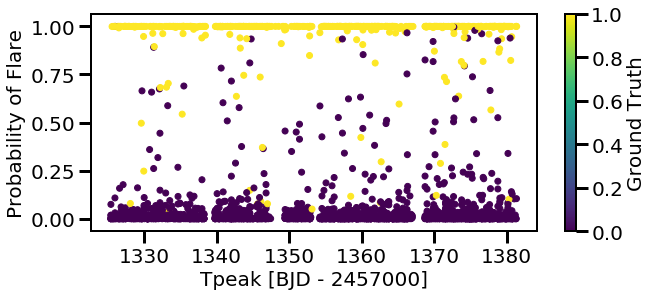

In [32]:
plt.figure(figsize=(10,4))
plt.scatter(cnn.val_pred_table['tpeak'], cnn.val_pred_table['pred_s0002'],
            c=cnn.val_pred_table['gt'], vmin=0, vmax=1)
plt.xlabel('Tpeak [BJD - 2457000]')
plt.ylabel('Probability of Flare')
plt.colorbar(label='Ground Truth');

Most of the points with high probabilities are actually flares (ground truth = 1), which is great! The CNN is not perfect, but here is where ensembling a bunch of different models with different initial random seeds. By averaging across models, you can beat down the number of false positives (no flares with high probabilities) and false negatives (flares with low probabilities).

#### 1.3 Evaluating your Model

How do you know if the model you created and trained is good? There are a few different metrics you can look at. The first is looking at your loss and accuracy histories. Here are some features you should look for:

- If your training and validation loss smoothly decline and flatten out at a low number, that's good!

- If your validation loss traces your training loss, that's good!

- If your validation loss starts to increase, your model is beginning to overfit. Rerun the model for fewer epochs and this should solve the issue.

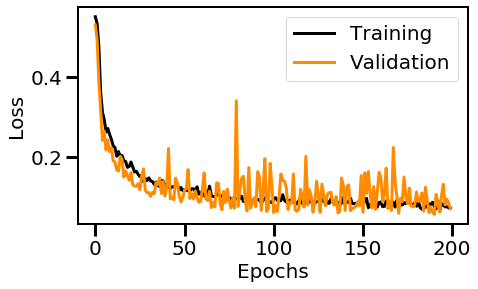

In [33]:
plt.figure(figsize=(7,4))
plt.plot(cnn.history_table['loss_s0002'], 'k', label='Training', lw=3)
plt.plot(cnn.history_table['val_loss_s0002'], 'darkorange', label='Validation', lw=3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

Some of the same rules as above apply here:

- If your accuracy increases smoothly and levels out at a high number, that's good! It means your model is at that leveling value % accuracy.

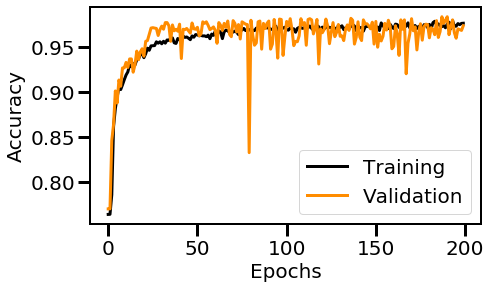

In [35]:
plt.figure(figsize=(7,4))
plt.plot(cnn.history_table['accuracy_s0002'], 'k', label='Training', lw=3)
plt.plot(cnn.history_table['val_accuracy_s0002'], 'darkorange', label='Validation', lw=3)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

#### 1.4 Predicting Flares in your Data

The function to predict on light curves takes care of the pre-processing for you. All you have to do is pass in an array of times, fluxes, and flux errors. So load in your files in whatever manner you like. For this example, we'll call a light curve using lightkurve.

//anaconda3/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


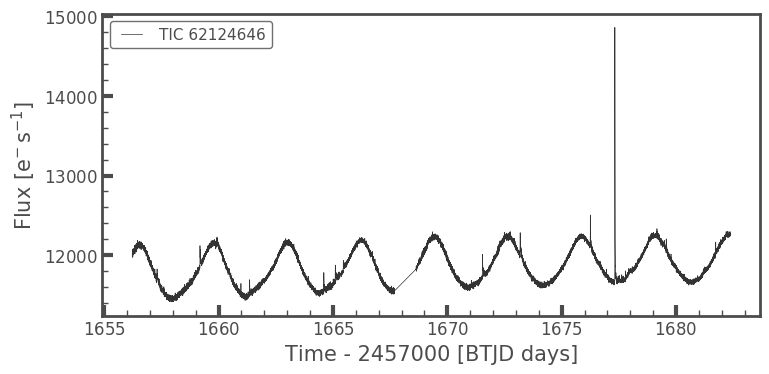

In [37]:
#### create a lightkurve for a two minute target here for the example
from lightkurve.search import search_lightcurvefile
lc = search_lightcurvefile(target='tic62124646', mission='TESS')
lc = lc.download().PDCSAP_FLUX
lc.plot()

Now we can use the model we saved to predict flares on new light curves! This is where it becomes important to keep track of your models and your output directory. To be extra sure you know what model you're using, in order to predict on new light curves you $\textit{must}$ input the model filename.

In [38]:
cnn.predict(modelname='/Users/arcticfox/Desktop/results/ensemble_s0002_i0050_b0.73.h5',
            times=lc.time, 
            fluxes=lc.flux, 
            errs=lc.flux_err)

100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Et voila... Predictions!

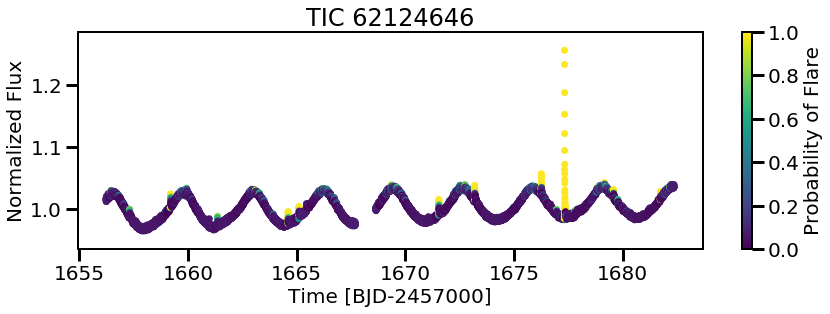

In [39]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=cnn.predictions[0], vmin=0, vmax=1)
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.title('TIC {}'.format(lc.targetid));